In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from torch import nn, optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import copy
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
df_train = pd.read_csv('data/ECG5000_TRAIN.txt',delim_whitespace=True,header=None)
df_test = pd.read_csv('data/ECG5000_TEST.txt',delim_whitespace=True,header=None)

In [5]:
df_train[0].value_counts()

1.0    292
2.0    177
4.0     19
3.0     10
5.0      2
Name: 0, dtype: int64

In [6]:
df_test[0].value_counts()

1.0    2627
2.0    1590
4.0     175
3.0      86
5.0      22
Name: 0, dtype: int64

In [7]:
df = df_train.append(df_test)
df = df.sample(frac=1.0,random_state=RANDOM_SEED)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
1001,1.0,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,...,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932
2086,1.0,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,...,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517
2153,1.0,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,...,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489
555,1.0,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,...,0.509497,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843
205,1.0,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,...,0.299639,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676


In [9]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

In [10]:
new_columns = list(df.columns)
new_columns[0] = 'target'
df.columns = new_columns

In [11]:
df.target.value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: target, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


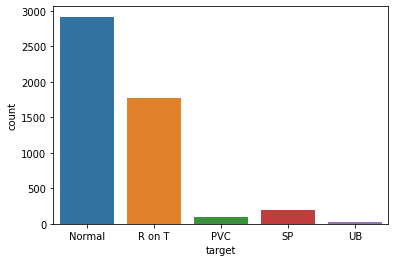

In [12]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [13]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.25
    )
    ax.set_title(class_name)

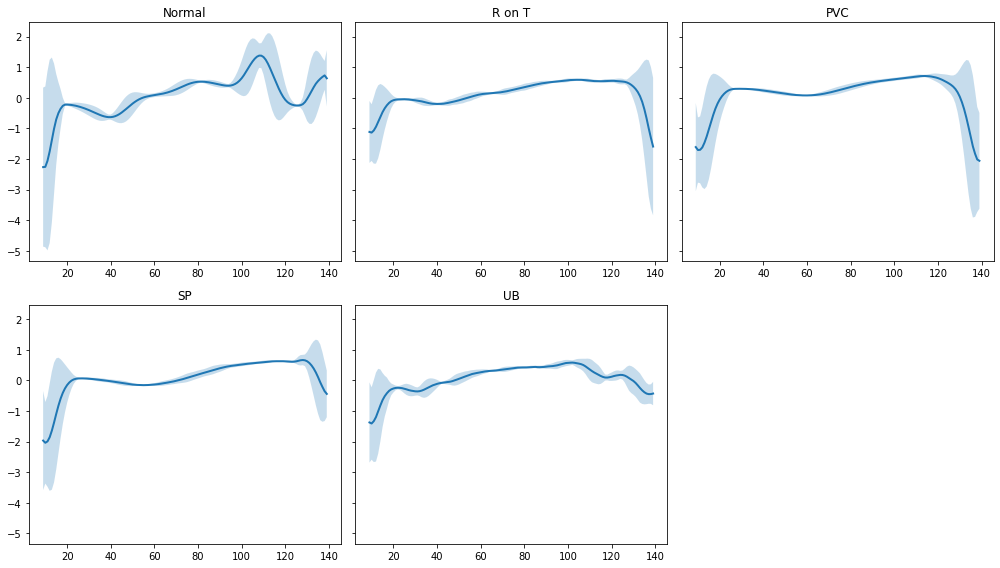

In [14]:
classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [15]:
normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [16]:
anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [17]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [18]:
print(train_df.shape, val_df.shape, test_df.shape)

(2481, 140) (293, 140) (145, 140)


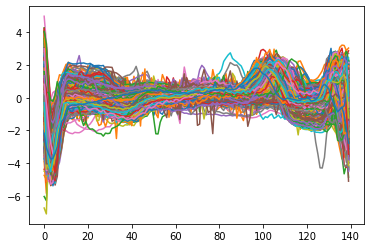

In [19]:
for i in range(0, train_df.shape[0]):
    plt.plot(list(train_df.iloc[i]))

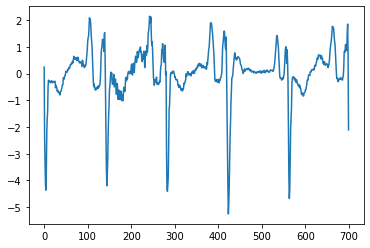

In [20]:
plt.plot(np.concatenate(([train_df.iloc[i] for i in range(5)])))

In [21]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [22]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [23]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [24]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [25]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [27]:
print(model)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [28]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [29]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=10
)

KeyboardInterrupt: 

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

In [30]:
model = torch.load('model2.pth')
model = model.to(device)

In [31]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

(0.0, 100.0)

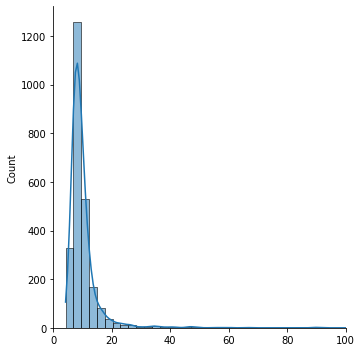

In [89]:
_, losses = predict(model, train_dataset)

sns.displot(losses, bins=50, kde=True);
plt.xlim(0,100)

In [51]:
THRESHOLD = 26

(0.0, 100.0)

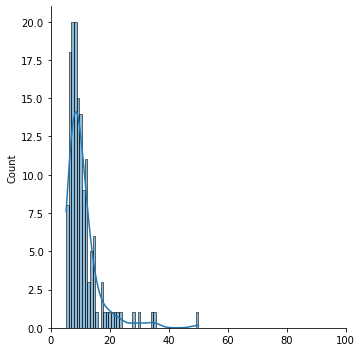

In [88]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.displot(pred_losses, bins=50, kde=True);
plt.xlim(0,100)

In [62]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}, Accuracy: {correct/len(test_normal_dataset)*100:0.2f}%')

Correct normal predictions: 140/145, Accuracy: 96.55%


In [63]:
anomaly_dataset = test_anomaly_dataset[:]

(0.0, 100.0)

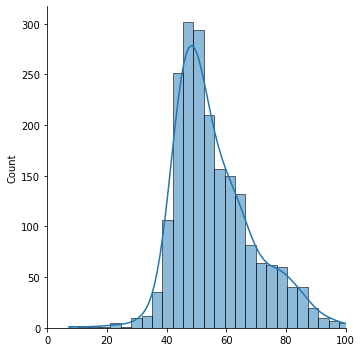

In [90]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.displot(pred_losses, bins=50, kde=True);
plt.xlim(0,100)

In [65]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}, Accuracy: {correct/len(anomaly_dataset)*100:.2f}%')

Correct anomaly predictions: 2070/2081, Accuracy: 99.47%


In [80]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='Truth')
    ax.plot(predictions[0], label='Reconstructed')
    ax.set_title(f'{title} (MAE: {np.around(pred_losses[0], 2)})')
    ax.legend()

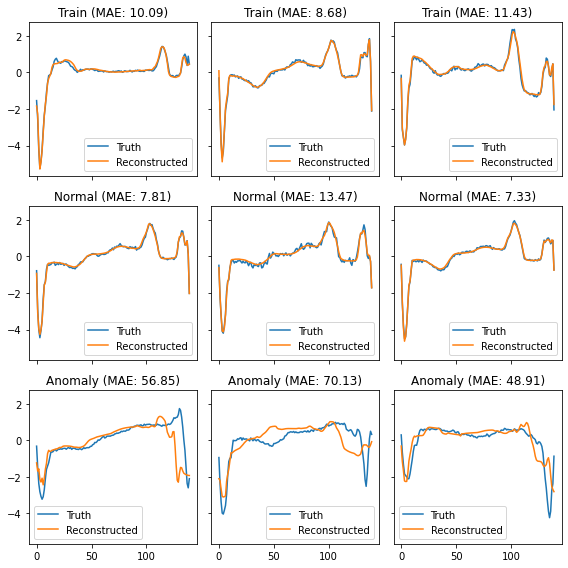

In [86]:
fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    sharey=True,
    sharex=True,
    figsize=(8, 8)
)

for i, data in enumerate(train_dataset[3:6]):
    plot_prediction(data, model, title='Train', ax=axs[0, i])

for i, data in enumerate(test_normal_dataset[:3]):
    plot_prediction(data, model, title='Normal', ax=axs[1, i])

for i, data in enumerate(test_anomaly_dataset[:3]):
    plot_prediction(data, model, title='Anomaly', ax=axs[2, i])

fig.tight_layout();